In [1]:
from evaluate_sdfdqn import *

In [2]:
# experiment configuration #
num_blocks = 3
max_blocks = 6
threshold = 2.5
max_steps = 20
gpu = 0
num_trials = 10
model = 'rulebased'
adj_ver = 0
selfloop = False
graph_normalize = False
resize = True
separate = False
bias = False
clip_sdf = False
round_sdf = False
depth = False
tracker = False
convex_hull = False
segmentation = False

In [3]:
# SDF module & Environment #
sdf_module = SDFModule(rgb_feature=True, resnet_feature=True, convex_hull=convex_hull, 
            binary_hole=True, using_depth=depth, tracker=False, resize=resize)
ur5robot = UR5Robot()
env = RealSDFEnv(ur5robot, sdf_module, num_blocks=num_blocks)

/home/dof6/Desktop/hogun_ur5/realrobot/../UnseenObjectClustering/fcn/config.py:439: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  yaml_cfg = edict(yaml.load(f))


In [4]:
def show_img(imgs, vmin=0.56, vmax=0.6):
    color, depth = imgs
    color = sdf_module.remove_background(color)
    plt.subplot(1, 2, 1)
    plt.imshow(color)
    plt.subplot(1, 2, 2)
    plt.imshow(depth, vmin=vmin, vmax=vmax)

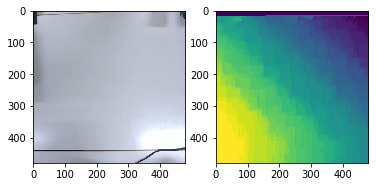

In [5]:
# 1. Reset Robot Arm & Set Background Image#
background_img, _ = env.reset()
sdf_module.set_background(background_img[1])
#env.ur5.realsense = RealSenseSensor("141322252613")
#env.ur5.realsense.frames(spatial=True, hole_filling=True, temporal=True)

show_img(background_img)

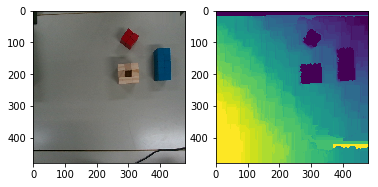

In [6]:
# 2. Set Goal Scene #
env.set_goals()
show_img(env.goals)

In [7]:
# 3. Init Scene #
(state_img, goal_img) = env.reset()

sdf_st, sdf_raw, feature_st = sdf_module.get_sdf_features_with_ucn(state_img[0], state_img[1], env.num_blocks, clip=clip_sdf)
sdf_g_b, _, feature_g = sdf_module.get_sdf_features_with_ucn(goal_img[0], goal_img[1], env.num_blocks, clip=clip_sdf)
sdf_g = sdf_module.make_round_sdf(sdf_g_b) if round_sdf else sdf_g_b

Text(0.5,1,'Observation')

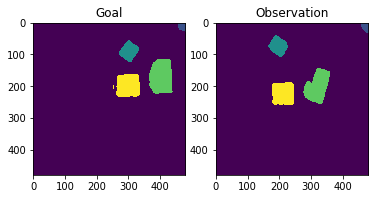

In [8]:
plt.subplot(1, 2, 1)
plt.imshow(sdf_module.detect_objects(goal_img[0], goal_img[1], 'HWC'))
plt.title('Goal')
plt.subplot(1, 2, 2)
plt.imshow(sdf_module.detect_objects(state_img[0], state_img[1], 'HWC'))
plt.title('Observation')

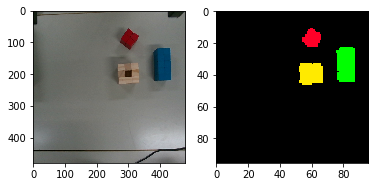

In [9]:
# Visualize Goal Scene #
sdf_res = 96
cm = pylab.get_cmap('gist_rainbow')

vis_g = norm_npy(0*sdf_g_b + 2*(sdf_g_b>0).astype(float))
goal_sdfs = np.zeros([sdf_res, sdf_res, 3])
for _s in range(len(vis_g)):
    goal_sdfs += np.expand_dims(vis_g[_s], 2) * np.array(cm(_s/5)[:3])

plt.subplot(1, 2, 1)
plt.imshow(goal_img[0])
plt.subplot(1, 2, 2)
plt.imshow(norm_npy(goal_sdfs))

In [10]:
# 4. Find Matching #
matching = sdf_module.object_matching(feature_st, feature_g)
sdf_st_align = sdf_module.align_sdf(matching, sdf_st, sdf_g)
sdf_raw = sdf_module.align_sdf(matching, sdf_raw, np.zeros([sdf_g.shape[0], *sdf_raw.shape[1:]]))

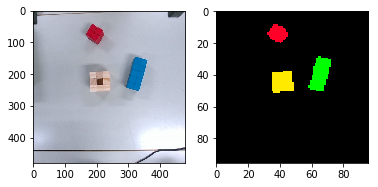

In [11]:
# Visualize Current Scene #
vis_c = norm_npy(0*sdf_st_align + 2*(sdf_st_align>0).astype(float))
current_sdfs = np.zeros([sdf_res, sdf_res, 3])
for _s in range(len(vis_c)):
    current_sdfs += np.expand_dims(vis_c[_s], 2) * np.array(cm(_s/5)[:3])

plt.subplot(1, 2, 1)
plt.imshow(state_img[0])
plt.subplot(1, 2, 2)
plt.imshow(norm_npy(current_sdfs))

In [12]:
# 5. Get Action #
action, q_map = get_rulebased_action(env, max_blocks, None, state_img[1], sdf_raw, \
                    [sdf_st_align, sdf_g], epsilon=0.1, with_q=True, \
                    target_res=sdf_res)
print(action)

[0, 0.0]


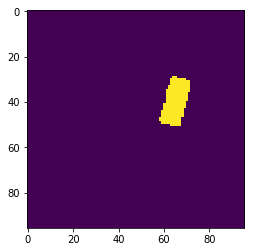

In [16]:
plt.imshow(sdf_st_align[2]>0)

In [21]:
action = [2, 1]

In [22]:
# 6. Pushing #
(next_state_img, _), reward, done, info = env.step(action, sdf_st_align, sdf_g)